# Importing  Necessary Libraries

In [2]:
import numpy as np #working with arrays and numerical calculations
import pandas as pd # load data
import matplotlib.pyplot as plt # plottting
import dask #scales data
import pyproj # photographic projections, such as lag/long into cartesian grid
import verde as vd #processing spatial data and gridding

# Want Figures Below to Be Larger

In [3]:
plt.rcParams["figure.dpi"] = 120 # make figures larger (more pixels) than default

## My Data

In [6]:
csv = pd.read_csv('DataBoxTest.csv')

# Recreate Scatterplot Using a Different Colormap

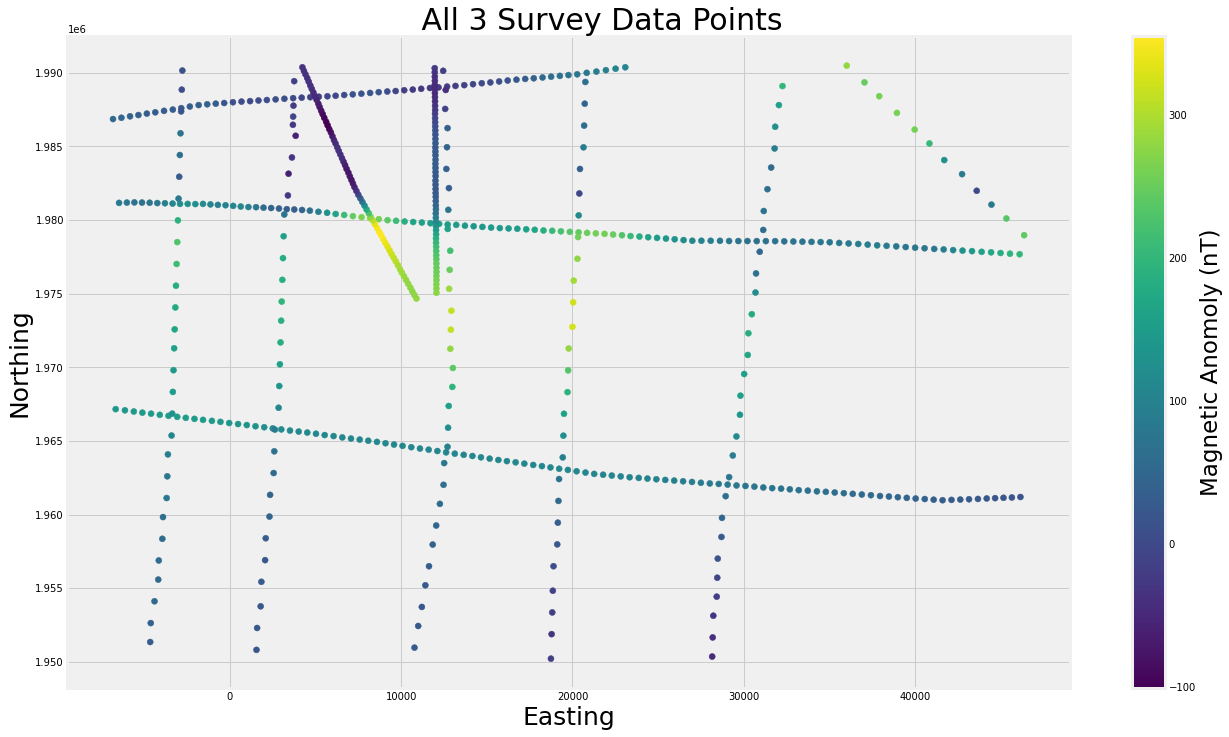

In [7]:
#Want to see better visualization of high/low values

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,12))

x = csv['X']
y = csv['Y']
colors = csv['MagAnomaly']


grid = plt.scatter(x, y, c=colors, cmap='viridis')
plt.title('       All 3 Survey Data Points',fontsize = 30)
plt.xlabel('Easting', fontsize = 25)
plt.ylabel('Northing', fontsize = 25)
cbar = plt.colorbar()
cbar.set_label('Magnetic Anomoly (nT)', fontsize = 23)
plt.grid(True)
plt.show()

In [6]:
# Adding different colors to show each survey

<Figure size 2016x1440 with 0 Axes>

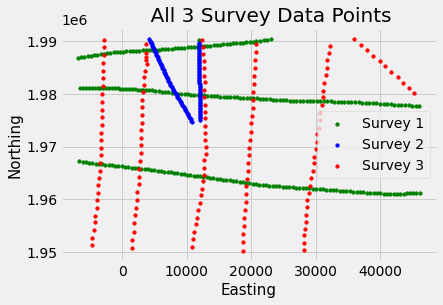

In [8]:
x = csv['X']
y = csv['Y']

survey_1_x = x[0:270]
survey_2_x = x[271:388]
survey_3_x = x[389:543]

survey_1_y = y[0:270]
survey_2_y = y[271:388]
survey_3_y = y[389:543]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(28,20))

fig, ax = plt.subplots()
survey_1 = ax.scatter(survey_1_x, survey_1_y, s=13, color = 'green')
survey_2 = ax.scatter(survey_2_x, survey_2_y, s=13, color = 'blue')
survey_3 = ax.scatter(survey_3_x, survey_3_y, s=13, color= 'red')
ax.legend([survey_1, survey_2, survey_3], ['Survey 1', 'Survey 2', 'Survey 3'])
plt.title('       All 3 Survey Data Points',fontsize = 20)
plt.xlabel('Easting', fontsize = 15)
plt.ylabel('Northing', fontsize = 15)

plt.grid(True)
plt.show()

# Quick Contour Map for even Better Visulation

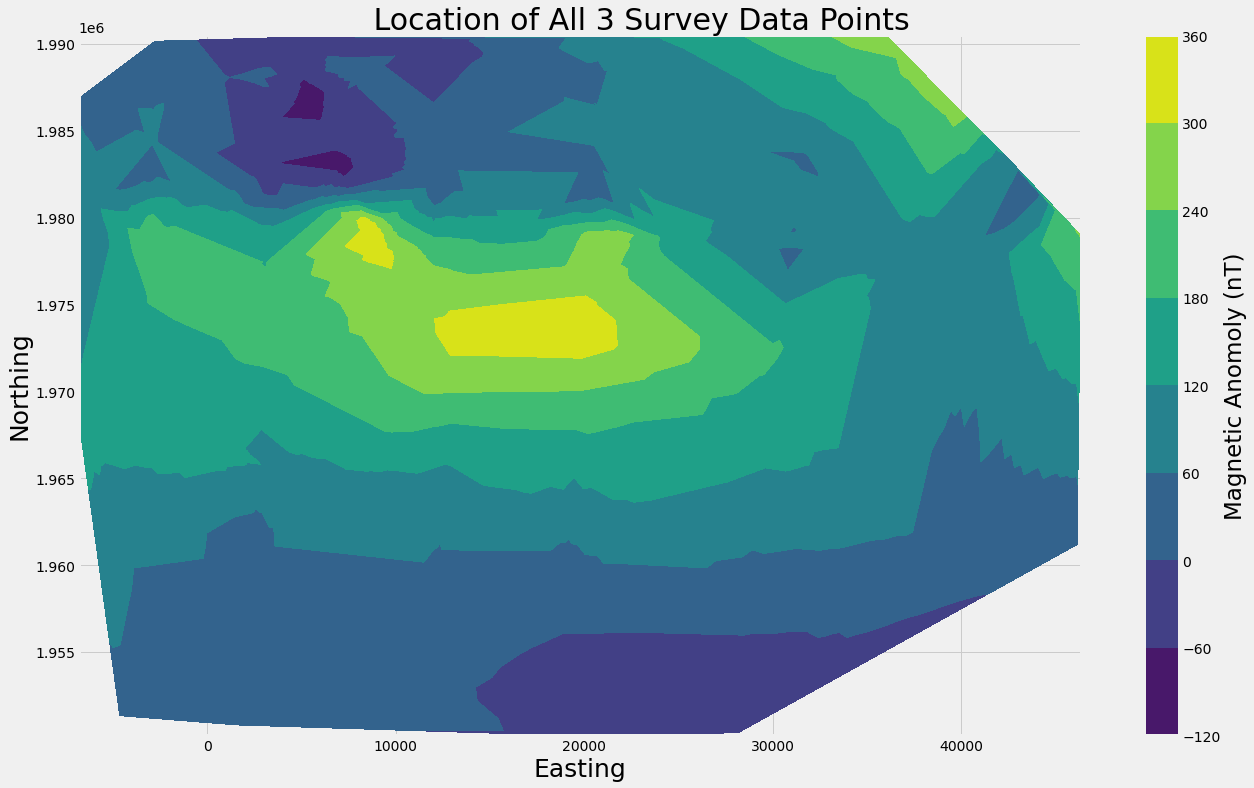

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,12))

x = csv['X']
y = csv['Y']
colors = csv['MagAnomaly']

plt.tricontourf(x,y, colors) #draws contours on an unstructured traingular grid
plt.title('             Location of All 3 Survey Data Points',fontsize = 30)
plt.xlabel('Easting', fontsize = 25)
plt.ylabel('Northing', fontsize = 25)
cbar = plt.colorbar()
cbar.set_label('Magnetic Anomoly (nT)', fontsize = 23)
plt.grid(True)
plt.show()


# Processing: Trends

In [10]:
#removal of 2D polynomial trends from the data

coordinates = (x,y)

#estimate polynomial coefficients for this trend
trend = vd.Trend(degree=1).fit(coordinates, csv.MagAnomaly)
print(trend.coef_)

#predict trend values and remove
trend_values = trend.predict(coordinates)
regional = csv.MagAnomaly - trend_values



[ 2.22302706e+03  4.47929674e-04 -1.08168152e-03]


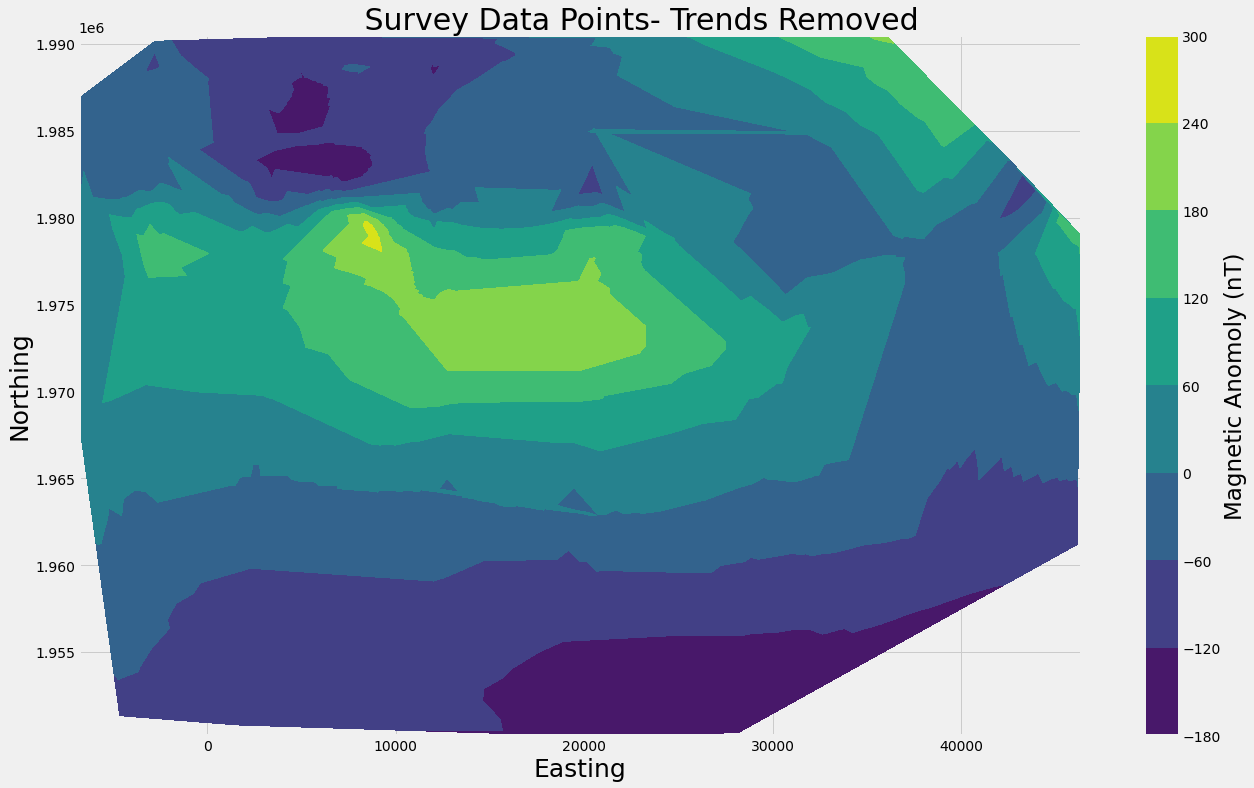

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,12))

plt.tricontourf(x,y, regional)
plt.title('             Survey Data Points- Trends Removed',fontsize = 30)
plt.xlabel('Easting', fontsize = 25)
plt.ylabel('Northing', fontsize = 25)
cbar = plt.colorbar()
cbar.set_label('Magnetic Anomoly (nT)', fontsize = 23)
plt.grid(True)
plt.show()

# Blocked Reductions

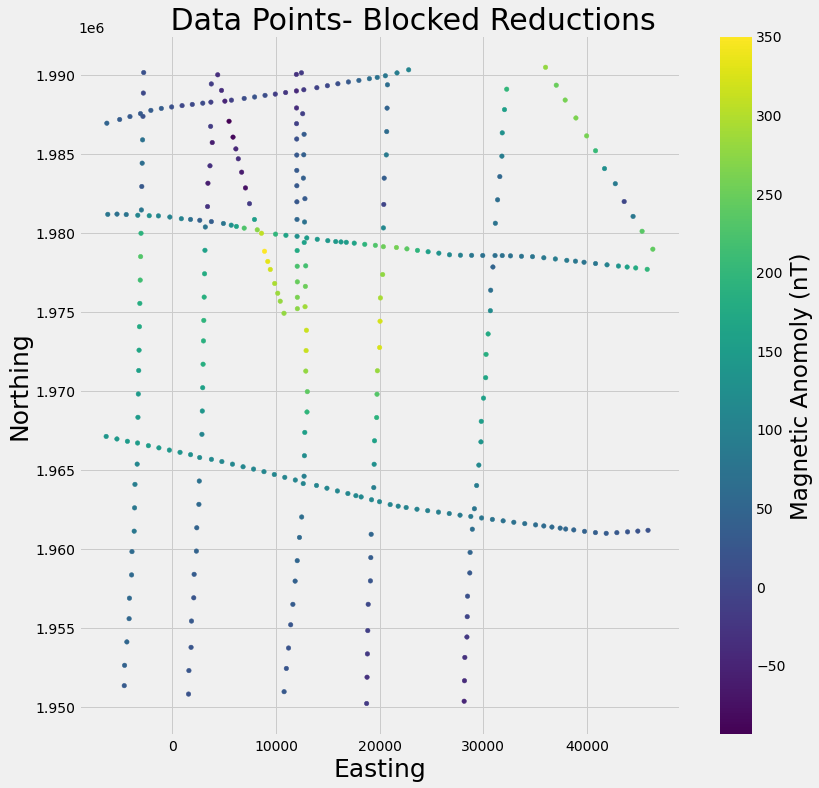

In [15]:

reducer = vd.BlockReduce(np.median, spacing=1000)

block_coords, block_mag = reducer.filter(coordinates, csv.MagAnomaly)

csv.shape
block_mag.shape

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,12))
plt.scatter(block_coords[0], block_coords[1], c=block_mag, s=20)
plt.title('       Data Points- Blocked Reductions',fontsize = 30)
plt.xlabel('Easting', fontsize = 25)
plt.ylabel('Northing', fontsize = 25)
cbar = plt.colorbar()
cbar.set_label('Magnetic Anomoly (nT)', fontsize = 23)
plt.grid(True)
plt.show()

In [13]:
csv.shape

(543, 6)

In [14]:
block_mag.shape

(317,)

# Weigh Uncertainty

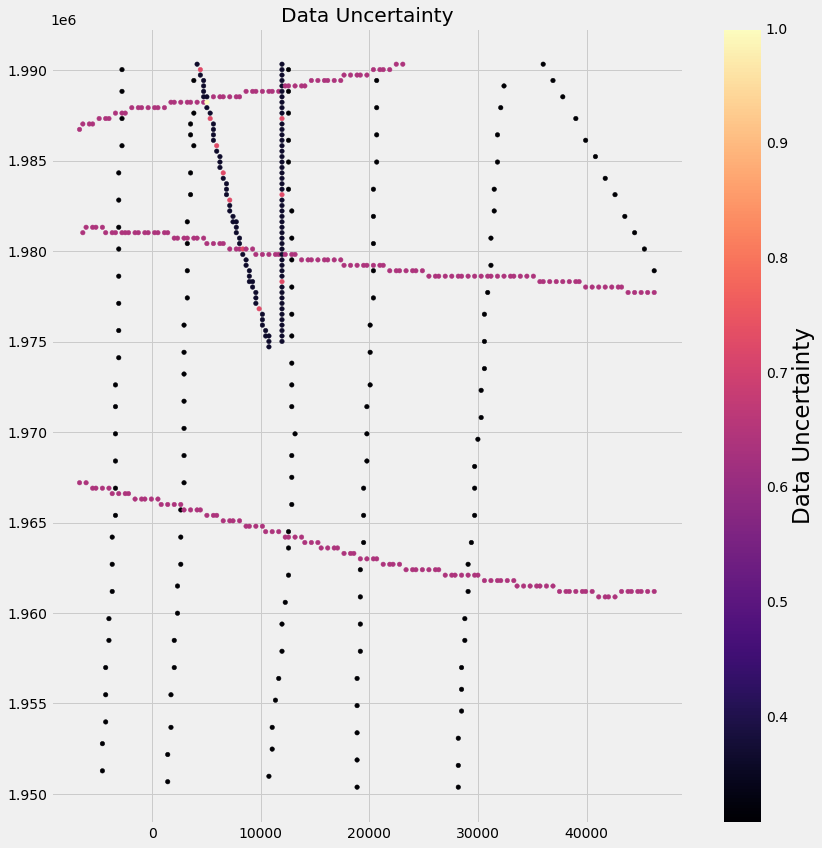

In [30]:
#introduce uncertainty

uncertainty = csv['uncertainty']

weight = 1 / (uncertainty**2)

spacing = 300

reducer = vd.BlockMean(spacing, center_coordinates=True)
# First produce the weighted variance weights
variance_weights = reducer.filter(coordinates, csv.MagAnomaly, weight)[-1]
# And now produce the uncertainty propagation weights
reducer.set_params(uncertainty=True)
block_coords, block_mag, weight_uncertainty = reducer.filter(coordinates, csv.MagAnomaly, weight)




plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,12))
plt.scatter(block_coords[0], block_coords[1], c=weight_uncertainty,cmap='magma', s=20)
cbar = plt.colorbar()
cbar.set_label('Data Uncertainty', fontsize = 23)
plt.title("Data Uncertainty")
plt.tight_layout()
plt.show()

# Interpolation: Gridding with splines

In [268]:
#bi-harmonic spline model


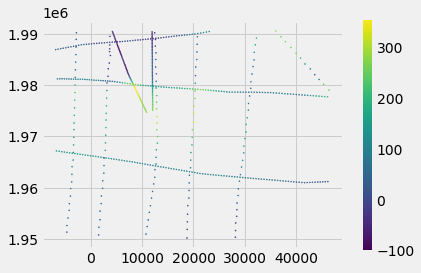

In [31]:
#fit the model and predict

spline = vd.Spline()
spline.fit(block_coords, block_mag)
predicted = spline.predict(coordinates)


plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=predicted, s=1)
plt.axis("scaled")
plt.colorbar()

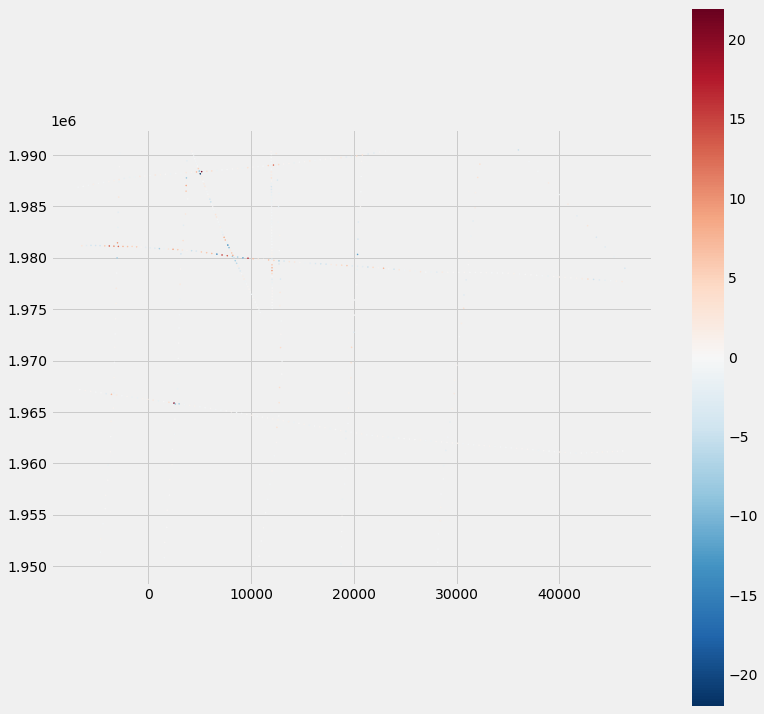

In [46]:
spline_residual = csv.MagAnomaly - predicted

scale = vd.maxabs(spline_residual)

plt.figure(figsize=(12,12))
plt.scatter(coordinates[0], coordinates[1], c=spline_residual, s=1, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.axis("scaled")
plt.colorbar()

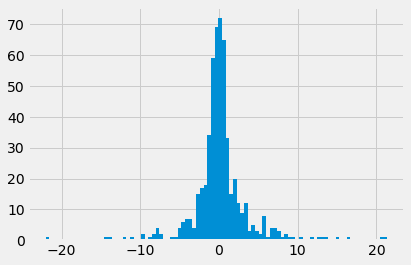

In [33]:
plt.figure()
plt.hist(spline_residual, bins="auto")
plt.show()

<Figure size 432x288 with 0 Axes>

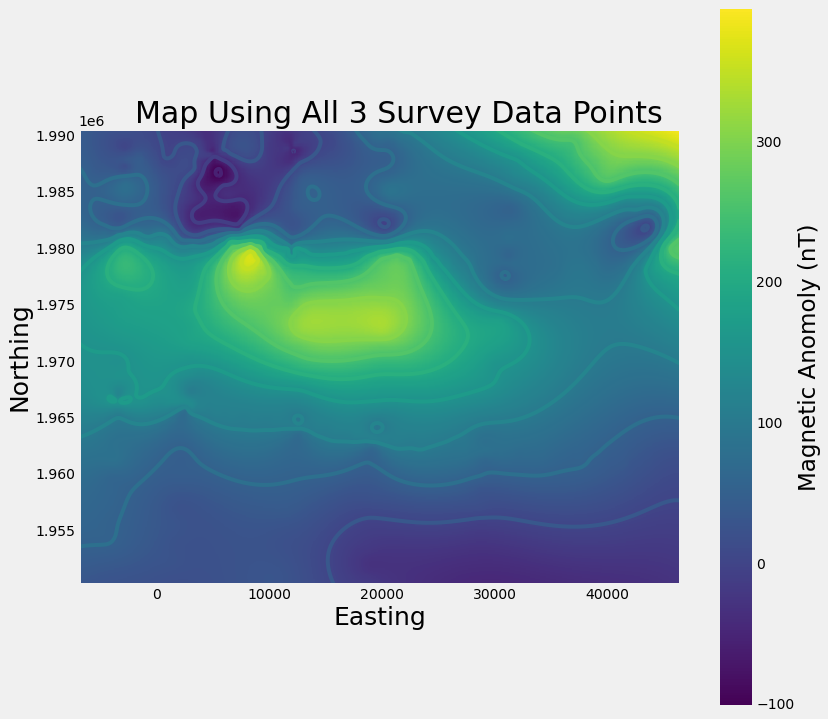

In [34]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=100)

grid_mag = spline.predict(grid_coords)

plt.figure()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,12))
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_mag)
plt.axis("scaled")
plt.title('    Map Using All 3 Survey Data Points',fontsize = 30)
plt.xlabel('Easting', fontsize = 25)
plt.ylabel('Northing', fontsize = 25)
cbar = plt.colorbar()
cbar.set_label('Magnetic Anomoly (nT)', fontsize = 23)
plt.contour(grid_coords[0], grid_coords[1], grid_mag, levels=10)